# info

This script will generate a heatmap of hypoteses A, B and E.

This is due to the following contrasts:
* Hypothesis A: laminar over static
* Hypothesis B is oscillatory over laminar
* Hypothesis C i osicllatory Pi over laminar Pi
* Hypothesis D is laminar Pi over laminar no Pi
* Hypothesis E is oscillatory Pi over oscillatory no Pi

In [1]:
import os, pandas, numpy, seaborn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(16, 9)})

In [3]:
colors = [(0, "blue"), (0.5-0.125, "white"), (0.5+0.125, "white"), (1, "red")]
bwwr = matplotlib.colors.LinearSegmentedColormap.from_list("bwwr", colors)

# 0. user-defined variables

In [4]:
DEG_called_folder = '/home/adrian/projects/hegoi/results/subsamples/sleuth/'
expression_file = '/home/adrian/projects/hegoi/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/home/adrian/projects/hegoi/metadata/hegoi metadata - hypotheses formatted for filter.tsv'

In [5]:
DEG_called_folder = '/Users/adrian/gd15/tmp/hegoi_tempo/sleuth/'
expression_file = '/Users/adrian/gd15/tmp/hegoi_tempo/DESeq2_TPM_values.tsv'
metadata_file = '/Users/adrian/gd15/tmp/hegoi_tempo/metadata/hegoi metadata - hypotheses formatted for filter.tsv'

In [6]:
working_hypotheses = ['A', 'B', 'E']

# 1. read data

## 1.1. read DEGs

In [7]:
file_names = os.listdir(DEG_called_folder)
file_names.remove('messages.txt')
file_names.sort()

degs = {}
for file_name in file_names:
    label = file_name.split('.csv')[0]
    df = pandas.read_csv(DEG_called_folder+file_name, index_col='target_id')
    ensembls = df.index.to_list()
    degs[label] = ensembls

## 1.2. read expression

In [8]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
print(expression.shape)
expression.head()

(40320, 26)


,Lam153,Lami154,Lami46,Lami94,LamiP109,LamiP153,LamiP154,LamiP176,LamiPi46,LamiPi94,...,OsciP154,OsciP175,OsciP178,OsciPi46,Stat109,Stat153,Stat154,Stat176,Stat46,Stat94
ENSG00000000003,24.240953,20.242011,22.919919,15.438227,18.098457,29.000777,14.784503,11.903633,26.217884,18.455471,...,38.756393,15.976121,21.649331,28.426877,29.688663,29.207002,28.989493,28.832380,34.600089,27.971771
ENSG00000000005,0.062960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013958,0.000000,0.139231
ENSG00000000419,59.982918,62.984443,120.871295,138.059565,115.707396,84.892000,172.643218,147.901176,145.183145,135.750959,...,98.473591,161.024012,86.023654,115.321222,64.464680,81.686544,84.388415,88.740844,81.992995,97.987628
ENSG00000000457,4.680221,3.684855,1.989328,3.244174,4.417648,2.189278,6.217483,3.998143,4.786793,2.949599,...,3.012943,1.024624,2.255165,2.967113,1.825466,2.371161,3.513856,2.617785,2.546863,2.668982
ENSG00000000460,1.982690,1.344508,1.422365,1.667403,0.570064,2.856698,0.416009,0.000000,1.310974,1.812507,...,5.510741,3.805323,1.489214,0.957885,4.467578,5.425887,7.680067,4.002537,3.650609,4.056977


## 1.3. read metadata

In [9]:
metadata = pandas.read_csv(metadata_file, sep='\t')
metadata = metadata[(metadata['hypothesis'] == 'hypothesis_A') | (metadata['hypothesis'] == 'hypothesis_B') | (metadata['hypothesis'] == 'hypothesis_E')]
metadata

,hypothesis,patient,sampleA,sampleB
0,hypothesis_A,46,Stat46,Lami46
1,hypothesis_A,153,Stat153,Lam153
2,hypothesis_A,154,Stat154,Lami154
3,hypothesis_A,94,Stat94,Lami94
4,hypothesis_B,46,Lami46,Osci46
5,hypothesis_B,153,Lam153,Osci153
6,hypothesis_B,154,Lami154,Osci154
15,hypothesis_E,46,Osci46,OsciPi46
16,hypothesis_E,109,Osci109,OsciP109
17,hypothesis_E,153,Osci153,OsciP153


In [10]:
samples = []
for working_hypothesis in working_hypotheses:
    label = 'hypothesis_{}'.format(working_hypothesis)
    
    sub = metadata[metadata['hypothesis'] == label]
    
    samplesA = sub['sampleA'].to_list()
    samplesB = sub['sampleB'].to_list()
    both = samplesA + samplesB
    
    for element in both:
        samples.append(element)
    
working_samples = list(set(samples))
print(working_samples)

['Osci46', 'Lami154', 'Lam153', 'Osci153', 'Lami94', 'Osci154', 'OsciP109', 'OsciPi46', 'Stat46', 'Osci109', 'OsciP153', 'OsciP154', 'Stat154', 'Lami46', 'Stat153', 'Stat94']


# 2. select response genes

Response genes should pass the log2FC > 1 and have P < 0.05 for at least n-1 samples.

In [11]:
def response_gene_finder(ensembl, hypo, patient):
    
    success = True
    
    # filter 1 --- called by sleuth
    label = '{}_{}'.format(hypo_label, patient)
    if ensembl not in degs[label]:
        success = False
        
    # filter 2 --- abs log2FC > 1 and max. expr. > 1
    if success == True:
        labela = metadata[(metadata['hypothesis'] == hypo_label) & (metadata['patient'] == patient)]['sampleA'].values[0]
        labelb = metadata[(metadata['hypothesis'] == hypo_label) & (metadata['patient'] == patient)]['sampleB'].values[0]
        expr_num = expression.loc[ensembl, labelb]; expr_den = expression.loc[ensembl, labela]
        abs_log2FC = numpy.abs(numpy.log2((expr_num+1)/(expr_den+1)))
        top = numpy.max([expr_num, expr_den])
        if abs_log2FC < 1 or top < 2:
            success = False
        #print('\t\t\t', abs_log2FC, top, success)
        
    return success

In [12]:
%%time
all_response_genes = []
for hypo in working_hypotheses:
    print('working with hypothesis {}'.format(hypo))
    hypo_label = 'hypothesis_{}'.format(hypo)
    sub = metadata[metadata['hypothesis'] == hypo_label]
    patients = sub['patient']
    #print(patients)
    #print('detected {} patients'.format(len(patients)))
    
    response_genes = []
    ### iterate each gene
    print('about to iterate genes')
    for ensembl in expression.index:
        #print('\t working with {}'.format(ensembl))
        
        ### iterate over patients to see if filters are passed in n - 1 patients
        successes = []
        for patient in patients:
            success = response_gene_finder(ensembl, hypo, patient)
            successes.append(success)
        if sum(successes) >= len(patients) - 1:
            response_genes.append(ensembl)
            #print('\t\t response found in {}/{} patients---included. '.format(sum(successes), len(patients)))
        #else:
            #print('\t\t response found in {}/{} patients---excluded.'.format(sum(successes), len(patients)))
    
    # number of genes identified
    print('{} response genes detected\n'.format(len(response_genes)))
    all_response_genes.append(set(response_genes))

# define the set of responding genes over all hypotheses
#for element in all_response_genes:
#    print(len(element))
all_response_genes = list(set().union(*all_response_genes))
print('overall, {} response genes detected'.format(len(all_response_genes)))

working with hypothesis A
about to iterate genes
821 response genes detected

working with hypothesis B
about to iterate genes
1021 response genes detected

working with hypothesis E
about to iterate genes
161 response genes detected

overall, 1539 response genes detected
CPU times: user 1min 44s, sys: 1.14 s, total: 1min 45s
Wall time: 1min 44s


# 3. build the heatmap

Patients 94 and 109 are excluded to calculate a consistent z-score

In [13]:
strict_metadata = metadata.drop(index=[3, 16])
strict_metadata

,hypothesis,patient,sampleA,sampleB
0,hypothesis_A,46,Stat46,Lami46
1,hypothesis_A,153,Stat153,Lam153
2,hypothesis_A,154,Stat154,Lami154
4,hypothesis_B,46,Lami46,Osci46
5,hypothesis_B,153,Lam153,Osci153
6,hypothesis_B,154,Lami154,Osci154
15,hypothesis_E,46,Osci46,OsciPi46
17,hypothesis_E,153,Osci153,OsciP153
18,hypothesis_E,154,Osci154,OsciP154


In [14]:
a = set(strict_metadata['sampleA'])
b = set(strict_metadata['sampleB'])
c = list(a.union(b))
c.sort()
print(c)

['Lam153', 'Lami154', 'Lami46', 'Osci153', 'Osci154', 'Osci46', 'OsciP153', 'OsciP154', 'OsciPi46', 'Stat153', 'Stat154', 'Stat46']


In [15]:
response_expression = expression.loc[all_response_genes, c]
print(response_expression.shape)

(1539, 12)


In [16]:
# compute z-score on expression in linear scale
zscore_df = scipy.stats.zscore(response_expression, axis=1)
zscore_df.head()

,Lam153,Lami154,Lami46,Osci153,Osci154,Osci46,OsciP153,OsciP154,OsciPi46,Stat153,Stat154,Stat46
ENSG00000079462,-0.776411,-1.197875,-0.760765,0.202030,0.956449,-0.311402,-1.177799,1.469385,-1.112484,1.675538,0.837366,0.195968
ENSG00000086619,1.618589,2.618467,-0.324076,-0.651258,-0.591233,0.137602,-0.357363,-0.717231,-0.056394,-0.672328,-0.611987,-0.392788
ENSG00000168542,0.189563,-0.454361,-0.699073,1.003348,-0.236032,-0.689882,-0.363476,-0.517179,-0.722152,2.899729,0.192750,-0.603235
ENSG00000277781,2.796441,0.771586,-1.144040,-0.343700,0.429670,-0.893500,-0.214296,0.220654,-0.419733,-0.633748,-0.697076,0.127742
ENSG00000074590,-0.825324,-0.936702,-1.573888,0.455020,2.062129,1.355815,-0.161653,-0.616090,-0.623262,-0.136582,0.920570,0.079967


In [17]:
top = numpy.max(numpy.max(zscore_df, axis=1))
bottom = numpy.min(numpy.min(zscore_df, axis=1))

print(top, bottom)

3.308173047715619 -2.1260750190001296


working with complete and cosine...


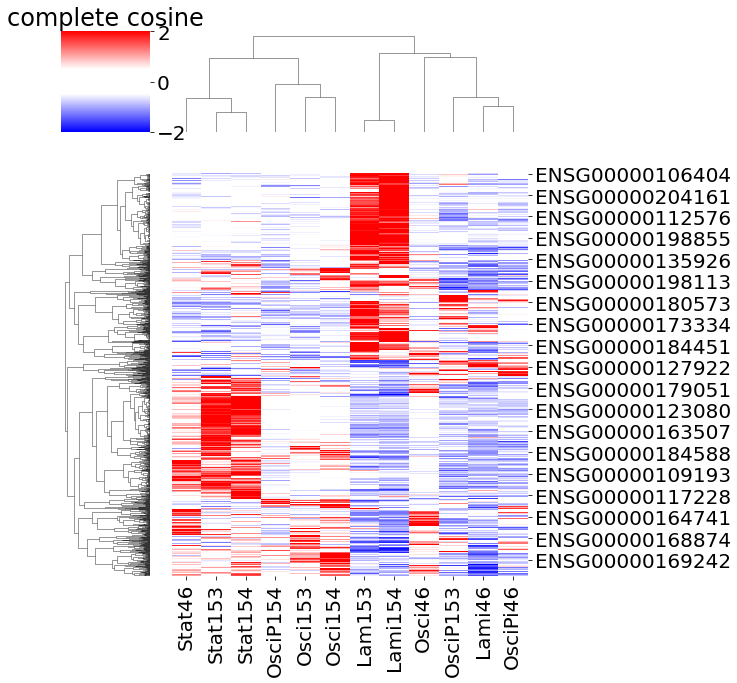

working with complete and euclidean...


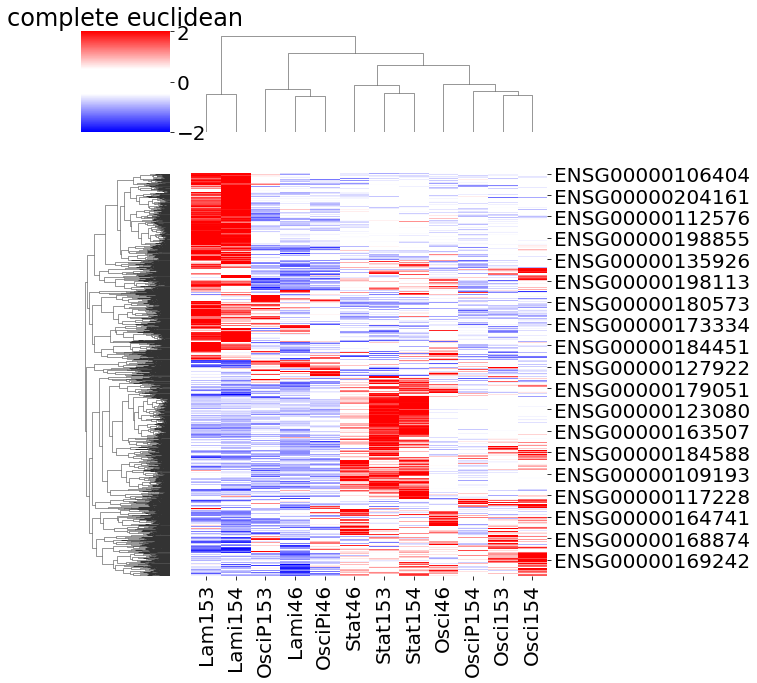

working with complete and correlation...


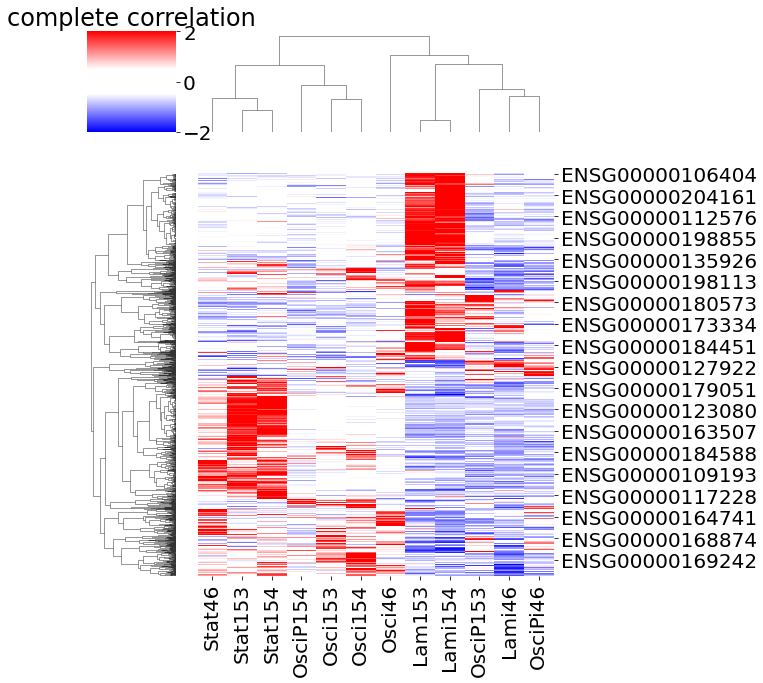

working with complete and braycurtis...


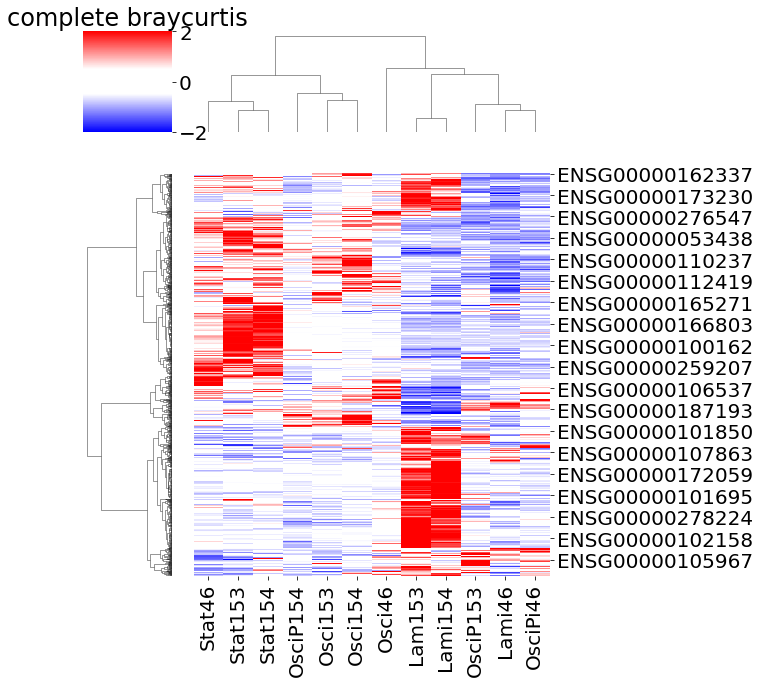

working with complete and chebyshev...


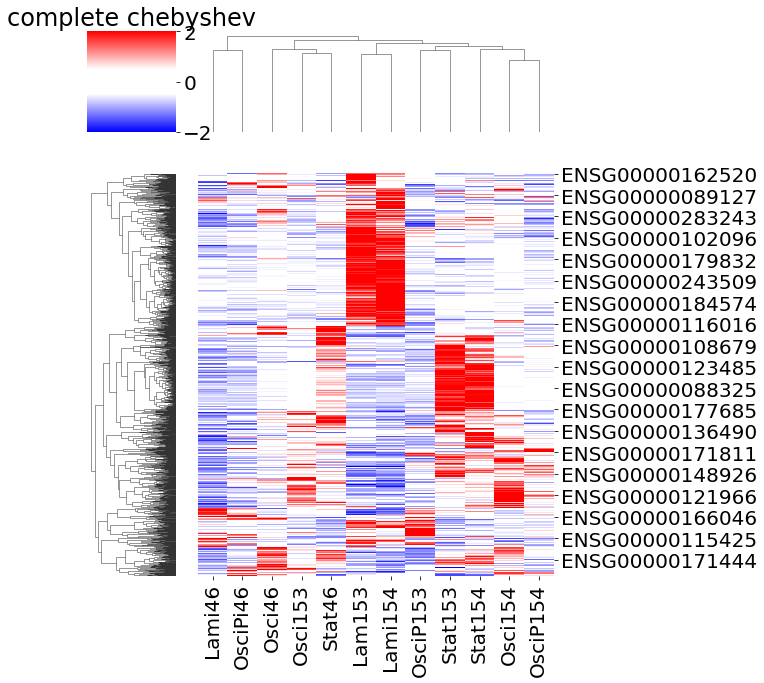

working with complete and seuclidean...


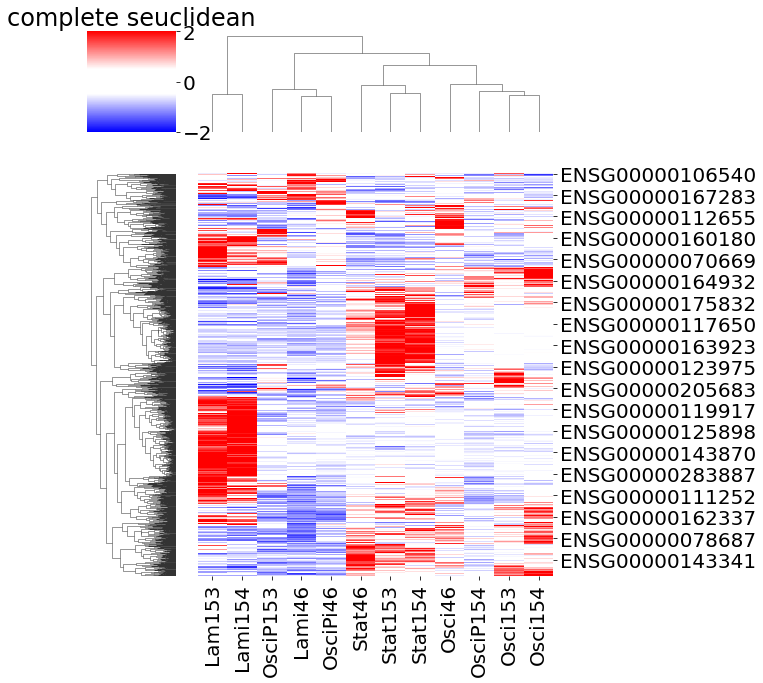

working with complete and minkowski...


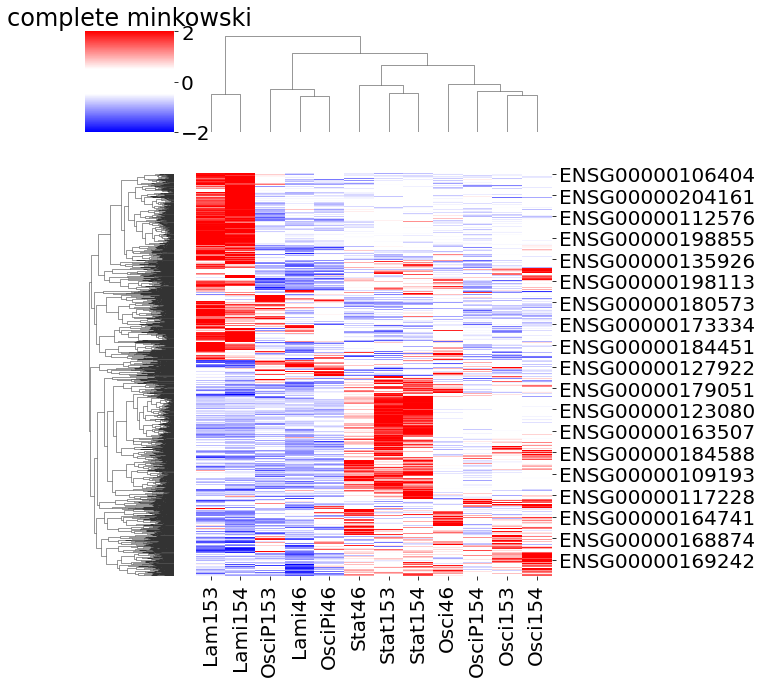

working with complete and sqeuclidean...


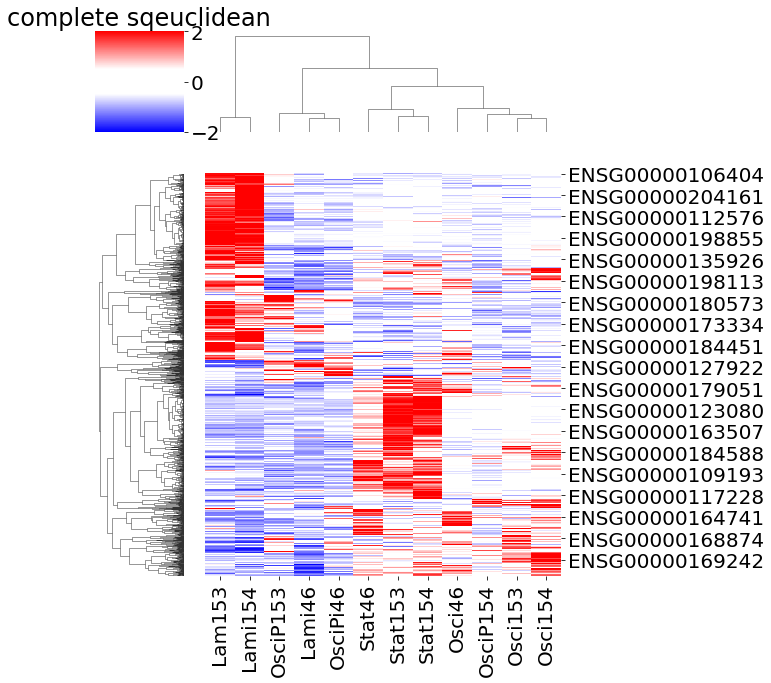

working with single and cosine...


ValueError: Linkage 'Z' contains negative distances.

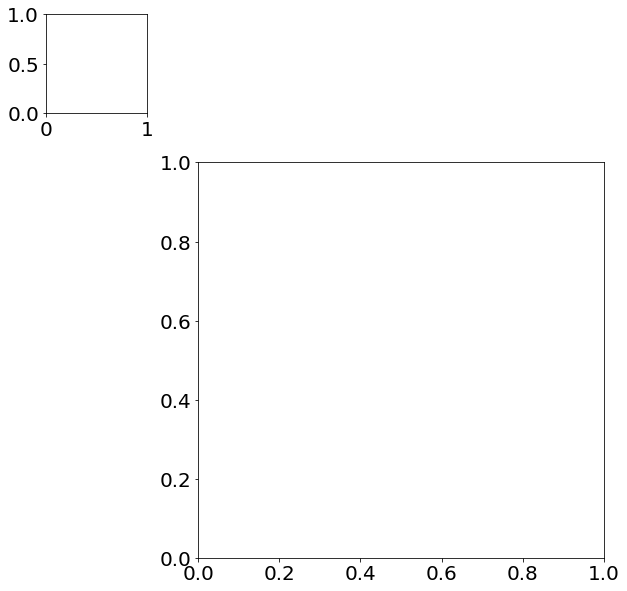

In [18]:
linkage_methods = ['complete', 'single', 'average', 'ward', 'weighted', 'centroid', 'median']
distance_metrics = ['cosine', 'euclidean', 'correlation', 'braycurtis', 'chebyshev', 'seuclidean', 'minkowski', 'sqeuclidean']

for linkage_method in linkage_methods:
    for distance_metric in distance_metrics:
        
        if linkage_method == 'single' and (distance_metric == 'chebyshev' or distance_metric == 'minkowski'):
            pass
        else:
    
            print('working with {} and {}...'.format(linkage_method, distance_metric))

            seaborn.clustermap(zscore_df, cmap=bwwr, method=linkage_method, metric=distance_metric, vmin=-2, vmax=2)

            matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.show()
            #matplotlib.pyplot.savefig('figures/{}.{}.pdf'.format(linkage_method, distance_metric))